In [3]:
!pip install split-folders

In [4]:

import math
import os
import numpy as np

# PYTORCH
import torch
from torch import optim, nn, utils, Tensor
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR, ReduceLROnPlateau
import torch.nn as nn
import torch.nn.functional as F
import splitfolders

# TORCHMETRICS & TORCHVISION
import torchmetrics
from torchvision import datasets, transforms
from torchvision.transforms import Compose, Normalize, Resize, ToTensor, RandAugment
from torchsummary import summary

# LIGHTNING MODULE
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, RichProgressBar, ModelCheckpoint, EarlyStopping

# PLOTTING & LOGGING
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
KAGGLE_INPUT_DIR = '/kaggle/input/forest/RawFireData'
KAGGLE_WORKING_DIR = '/kaggle/working/FireData'

In [7]:
torch.manual_seed(42)
np.random.seed(42)

In [8]:
batch_size = 32
img_height = 224
img_width = 224
learning_rate = 2e-4
epochs = 10
num_classes = 3

In [9]:
os.makedirs('/kaggle/working/FireData', exist_ok=True)

# Split the data
splitfolders.ratio(
    '/kaggle/input/forest/RawFireData', 
    output='/kaggle/working/FireData', 
    seed=42, 
    ratio=(.8, .1, .1), 
    move=False
)

Copying files: 7575 files [01:32, 82.09 files/s] 


In [10]:
class FireDataModule(pl.LightningDataModule):
    def __init__(self, path=KAGGLE_WORKING_DIR, batch_size=32, img_height=250, img_width=250):
        super().__init__()
        self.batch_size = batch_size
        self.img_height = img_height
        self.img_width = img_width
        self.PATH = path
        self.prepare_data_per_node = False
        self._log_hyperparams = False
        
    def prepare_data(self):
        # This method is called only once and on only one GPU
        # Used for downloading/preprocessing that should be done once
        pass

    def setup(self, stage=None):
        # Set transformations
        train_transform = Compose([
            Resize((self.img_height, self.img_width)),
            RandAugment(num_ops=2, magnitude=9),
            ToTensor(),
            Normalize(0.5, 0.5)
        ])

        val_transform = Compose([
            Resize((self.img_height, self.img_width)),
            ToTensor(),
            Normalize(0.5, 0.5)
        ])
        
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            data_dir = os.path.join(self.PATH, 'train')
            self.train = datasets.ImageFolder(data_dir, transform=train_transform)
            
            data_dir = os.path.join(self.PATH, 'val')
            self.validate = datasets.ImageFolder(data_dir, transform=val_transform)
            
            print(f"Training dataset size: {len(self.train)}")
            print(f"Validation dataset size: {len(self.validate)}")
            print(f"Class mapping: {self.train.class_to_idx}")

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            data_dir = os.path.join(self.PATH, 'test')
            self.test = datasets.ImageFolder(data_dir, transform=val_transform)
            print(f"Test dataset size: {len(self.test)}")
            
    # Define dataloaders with appropriate num_workers for Kaggle
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.validate, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=2)

    def predict_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, num_workers=2)

In [11]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        n_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, embed_dim))
        
        # Linear projection
        self.proj = nn.Conv2d(
            in_channels, 
            embed_dim, 
            kernel_size=patch_size, 
            stride=patch_size
        )
        
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H//patch_size, W//patch_size)
        x = x.flatten(2)  # (B, embed_dim, H*W//patch_size^2)
        x = x.transpose(1, 2)  # (B, H*W//patch_size^2, embed_dim)
        return x

In [12]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert self.head_dim * num_heads == embed_dim, "embed_dim must be divisible by num_heads"
        
        # Linear projections
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (B, N, embed_dim)
        B, N, C = x.shape
        
        # Project to query, key, value
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # (B, num_heads, N, head_dim)
        
        # Attention
        attn = (q @ k.transpose(-2, -1)) * (self.head_dim ** -0.5)  # (B, num_heads, N, N)
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)
        
        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)  # (B, N, embed_dim)
        x = self.proj(x)
        x = self.dropout(x)
        
        return x

In [13]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, dropout=0.1):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features * 4
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = MLP(
            in_features=embed_dim,
            hidden_features=int(embed_dim * mlp_ratio),
            dropout=dropout
        )
        
    def forward(self, x):
        # Layer Normalization 1, Self-Attention, and Residual connection
        x = x + self.attn(self.norm1(x))
        # Layer Normalization 2, MLP, and Residual connection
        x = x + self.mlp(self.norm2(x))
        return x

In [15]:
class ViTForFireDetection(pl.LightningModule):
    def __init__(
        self,
        img_size=224,
        patch_size=16,
        in_channels=3,
        num_classes=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        mlp_ratio=4.0,
        dropout=0.1,
        learning_rate=2e-4
    ):
        super().__init__()
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.img_size = img_size  # Store image size
        self.patch_size = patch_size  # Store patch size
        
        # Save hyperparameters
        self.save_hyperparameters()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        
        # Calculate patches directly
        n_patches = (img_size // patch_size) ** 2
        
        # Class token and position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        # Layer normalization
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classifier head
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.initialize_weights()
        
        # Metrics
        self.train_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        
        # Save training history
        self.training_history = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        
    def initialize_weights(self):
        # Initialize patch_embed like a linear layer
        nn.init.xavier_uniform_(self.patch_embed.proj.weight)
        nn.init.zeros_(self.patch_embed.proj.bias)
        
        # Initialize cls_token
        nn.init.normal_(self.cls_token, std=1e-6)
        
        # Initialize position embedding
        nn.init.normal_(self.pos_embed, std=0.02)
        
        # Initialize all linear layers and layer norms
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        
    def forward(self, x):
        B = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)
        
        # Add class token
        cls_token = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)  # (B, 1 + n_patches, embed_dim)
        
        # Check dimensions and interpolate position embeddings if needed
        if x.size(1) != self.pos_embed.size(1):
            pos_embed = self.pos_embed
            cls_pos_embed = pos_embed[:, 0:1, :]
            other_pos_embed = pos_embed[:, 1:, :]
            
            n_h = n_w = self.img_size // self.patch_size
            other_pos_embed = other_pos_embed.reshape(1, n_h, n_w, -1).permute(0, 3, 1, 2)
            target_h = target_w = int(((x.size(1) - 1) ** 0.5))
            other_pos_embed = F.interpolate(
                other_pos_embed, size=(target_h, target_w), mode='bicubic', align_corners=False
            )
            other_pos_embed = other_pos_embed.permute(0, 2, 3, 1).reshape(1, target_h * target_w, -1)
            new_pos_embed = torch.cat([cls_pos_embed, other_pos_embed], dim=1)
            x = x + new_pos_embed
        else:
            x = x + self.pos_embed
        
        x = self.pos_drop(x)
        
        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)
        
        # Apply layer normalization
        x = self.norm(x)
        
        # Take only the class token for classification
        x = x[:, 0]
        
        # Apply classification head
        x = self.head(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.train_acc(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc, prog_bar=True)
        
        return loss
    
    def on_train_epoch_end(self):
        # Store values for plotting
        self.training_history['train_loss'].append(self.trainer.callback_metrics['train_loss'].item())
        self.training_history['train_acc'].append(self.trainer.callback_metrics['train_acc'].item())
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.val_acc(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc, prog_bar=True)
        
        return loss
    
    def on_validation_epoch_end(self):
        # Store values for plotting
        self.training_history['val_loss'].append(self.trainer.callback_metrics['val_loss'].item())
        self.training_history['val_acc'].append(self.trainer.callback_metrics['val_acc'].item())
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # Log metrics
        self.test_acc(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc, prog_bar=True)
        
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        preds = torch.argmax(logits, dim=1)
        return preds
    
    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=0.05
        )
        
        # Cosine annealing learning rate scheduler
        scheduler = CosineAnnealingLR(
            optimizer,
            T_max=epochs,
            eta_min=1e-6
        )
        
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1
            }
        }
    
    def on_test_end(self):
        # This method is called after test to visualize confusion matrix
        # You can implement custom visualization here if needed
        pass
    
    def plot_training_history(self):
        """Plot the training and validation accuracy and loss."""
        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot training and validation accuracy
        ax1.plot(self.training_history['train_acc'], label='Training Accuracy')
        ax1.plot(self.training_history['val_acc'], label='Validation Accuracy')
        ax1.set_title('Model Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot training and validation loss
        ax2.plot(self.training_history['train_loss'], label='Training Loss')
        ax2.plot(self.training_history['val_loss'], label='Validation Loss')
        ax2.set_title('Model Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('/kaggle/working/training_history.png')
        plt.close()
        
        return '/kaggle/working/training_history.png'

In [16]:
# Function to visualize predictions
def visualize_predictions(model, data_loader, num_images=5):
    model.eval()
    images, labels, preds = [], [], []
    
    with torch.no_grad():
        for batch in data_loader:
            imgs, lbls = batch
            logits = model(imgs)
            predictions = torch.argmax(logits, dim=1)
            
            # Store only the required number of samples
            for i in range(len(imgs)):
                if len(images) < num_images:
                    images.append(imgs[i].cpu())
                    labels.append(lbls[i].item())
                    preds.append(predictions[i].item())
                else:
                    break
            
            if len(images) >= num_images:
                break
    
    # Plot the images with their predictions
    class_names = data_loader.dataset.classes
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    for i, (img, lbl, pred) in enumerate(zip(images, labels, preds)):
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        title_color = 'green' if lbl == pred else 'red'
        axes[i].set_title(f"True: {class_names[lbl]}\nPred: {class_names[pred]}", color=title_color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/predictions.png')
    plt.close()
    
    return '/kaggle/working/predictions.png'

In [17]:
def plot_confusion_matrix(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            imgs, lbls = batch
            logits = model(imgs)
            predictions = torch.argmax(logits, dim=1)
            
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(lbls.cpu().numpy())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_loader.dataset.classes)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    plt.close()
    
    return '/kaggle/working/confusion_matrix.png'

In [19]:
data_module = FireDataModule(
        batch_size=batch_size, 
        img_height=img_height, 
        img_width=img_width
    )
data_module.setup()

Training dataset size: 6060
Validation dataset size: 756
Class mapping: {'Fire': 0, 'Normal': 1, 'Smoke': 2}
Test dataset size: 759


In [20]:
model = ViTForFireDetection(
    img_size=224,
    patch_size=16,
    in_channels=3,
    num_classes=3,
    embed_dim=384,  # Smaller model for faster training
    depth=6,        # Reduced depth
    num_heads=6,    # Fewer attention heads
    learning_rate=2e-4
).to(device)

In [21]:
checkpoint_callback = ModelCheckpoint(
        monitor="val_acc",
        dirpath="/kaggle/working/checkpoints/",
        filename="vit-fire-detection-{epoch:02d}-{val_acc:.4f}",
        save_top_k=1,
        mode="max"
    )
    
early_stop_callback = EarlyStopping(
    monitor="val_acc",
    min_delta=0.00,
    patience=3,
    verbose=True,
    mode="max"
)

In [22]:
lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [23]:
trainer = pl.Trainer(
        max_epochs=epochs,
        accelerator='auto',
        callbacks=[checkpoint_callback, early_stop_callback, lr_monitor, RichProgressBar()]
    )

In [24]:
trainer.fit(model, data_module)

2025-04-25 03:48:38.658835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745552918.984241      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745552919.058822      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Training dataset size: 6060
Validation dataset size: 756
Class mapping: {'Fire': 0, 'Normal': 1, 'Smoke': 2}


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ patch_embed  │ PatchEmbedding     │  370 K │ train │
│ 1 │ pos_drop     │ Dropout            │      0 │ train │
│ 2 │ blocks       │ ModuleList         │ 10.6 M │ train │
│ 3 │ norm         │ LayerNorm          │    768 │ train │
│ 4 │ head         │ Linear             │  1.2 K │ train │
│ 5 │ train_acc    │ MulticlassAccuracy │      0 │ train │
│ 6 │ val_acc      │ MulticlassAccuracy │      0 │ train │
│ 7 │ test_acc     │ MulticlassAccuracy │      0 │ train │
│   │ other params │ n/a                │ 76.0 K │ n/a   │
└───┴──────────────┴────────────────────┴────────┴───────┘

Trainable params: 11.1 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.1 M                                                                                               
Total estimated model params size (MB): 44                                                                         
Modules in train mode: 81                                                                                          
Modules in eval mode: 0

Output()

In [25]:
def evaluate_model(model, data_module):
    # Test accuracy
    trainer = pl.Trainer(accelerator='auto')
    results = trainer.test(model, datamodule=data_module)
    print(f"Test accuracy: {results[0]['test_acc']:.4f}")
    
    # Get predictions for confusion matrix and visualization
    test_loader = data_module.test_dataloader()
    all_preds = []
    all_labels = []
    sample_images = []
    sample_labels = []
    sample_preds = []
    
    model.eval()
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            images = images.to(model.device)
            labels = labels.to(model.device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Save first batch for visualization
            if batch_idx == 0:
                for i in range(min(5, len(images))):
                    sample_images.append(images[i].cpu())
                    sample_labels.append(labels[i].item())
                    sample_preds.append(preds[i].item())
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = test_loader.dataset.classes
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title('Confusion Matrix')
    plt.savefig('/kaggle/working/confusion_matrix.png')
    
    # Plot sample predictions
    fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 3))
    for i, (img, true_label, pred_label) in enumerate(zip(sample_images, sample_labels, sample_preds)):
        # Denormalize image
        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}", color=color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/sample_predictions.png')
    
    return {
        'accuracy': results[0]['test_acc'],
        'confusion_matrix': '/kaggle/working/confusion_matrix.png',
        'sample_predictions': '/kaggle/working/sample_predictions.png'
    }


In [26]:
history_plot = model.plot_training_history()
print(f"Training history saved to: {history_plot}")

Training history saved to: /kaggle/working/training_history.png


Test dataset size: 759


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9736495614051819     │
│         test_loss         │    0.07761915028095245    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9736
Test accuracy: 0.9736
Confusion matrix saved to: /kaggle/working/confusion_matrix.png
Sample predictions saved to: /kaggle/working/sample_predictions.png


<Figure size 1000x800 with 0 Axes>

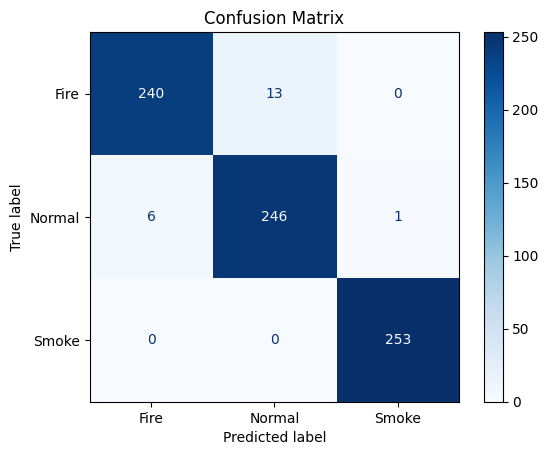

In [ ]:
eval_results = evaluate_model(model, data_module)
print(f"Test accuracy: {eval_results['accuracy']:.4f}")
print(f"Confusion matrix saved to: {eval_results['confusion_matrix']}")
print(f"Sample predictions saved to: {eval_results['sample_predictions']}")

In [ ]:
vis_path = visualize_predictions(model, data_module.test_dataloader())
print(f"Prediction visualization saved to: {vis_path}")